
# eBay Auctions (May–June 2004): EDA & Classification Trees

**Objective**: Predict whether an auction will be **competitive** (i.e., it receives at least two bids) using item, seller, and auction-setting features.


## Dataset & Variables

**File**: `ebayAuctions.xlsx` → **Sheet**: `eBay auctions`  
**Rows**: `1972` &nbsp;&nbsp; **Columns**: `8`

**Columns** (original):
- `Category` *(categorical)*: auction category (18 levels).
- `Currency` *(categorical)*: listing currency (`US`, `EUR`, `GBP`).
- `sellerRating` *(numeric)*: seller's eBay rating (non-negative integer, heavy-tailed).
- `Duration` *(numeric / discrete)*: length of auction in days (e.g., 1, 3, 5, 7, 10).
- `endDay` *(categorical)*: day of week the auction ends.
- `ClosePrice` *(numeric)*: final price at close (observed **after** auction).
- `OpenPrice` *(numeric)*: opening price set by seller.
- `Competitive?` *(binary 0/1)* → renamed to `Competitive`.

**Target**: `Competitive` (1 = competitive, 0 = non-competitive).


## Setup

In [1]:
DATA_PATH = "../Data/ebayAuctions.xlsx"

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree, export_text
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)
sns.set_theme(context="notebook", style="whitegrid")

RANDOM_STATE = 42

## Load data & initial checks

In [2]:
df = pd.read_excel(DATA_PATH, sheet_name="eBay auctions").rename(columns={"Competitive?":"Competitive"})

# Quick overview
display(df.head())
print("\nShape:", df.shape)
print("\nDtypes:")
print(df.dtypes)

# Basic sanity checks
print("\nMissing values:")
print(df.isna().sum())

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0



Shape: (1972, 8)

Dtypes:
Category         object
Currency         object
sellerRating      int64
Duration          int64
endDay           object
ClosePrice      float64
OpenPrice       float64
Competitive       int64
dtype: object

Missing values:
Category        0
Currency        0
sellerRating    0
Duration        0
endDay          0
ClosePrice      0
OpenPrice       0
Competitive     0
dtype: int64



## Task 1 — EDA & Data Preparation

We aim to:  
1. **Understand distributions** (skewness/heavy tails).  
2. **Detect outliers** (IQR rule & visual checks).  
3. **Decide transformations** (e.g., `log1p` for highly skewed prices/ratings).  
4. **Consider dropping** variables that are **not** useful or not available **before** the auction (for the practical model).  
5. Use **seaborn** to visualize relationships with `Competitive` for interpretability.


### 1. Univariate distributions

,OpenPrice,ClosePrice,sellerRating
count,1972.000000,1972.000000,1972.000000
mean,12.926268,36.449087,3560.238337
std,38.856149,89.493858,5973.011033
min,0.010000,0.010000,0.000000
25%,1.230000,4.907500,595.000000
50%,4.500000,9.995000,1853.000000
75%,9.990000,28.000000,3380.000000
max,999.000000,999.000000,37727.000000


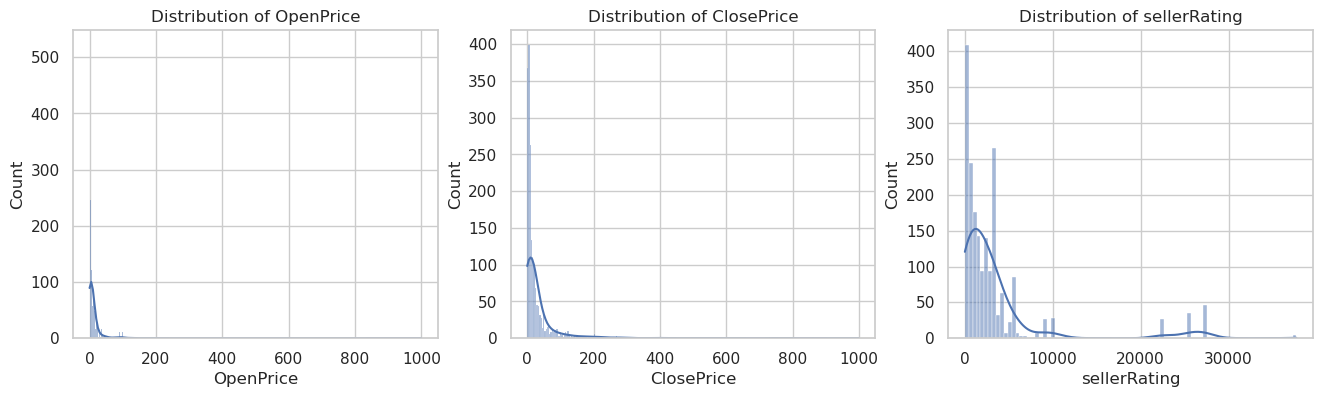

In [3]:
num_cols = ["OpenPrice", "ClosePrice", "sellerRating"]
cat_cols = ["Category", "Currency", "endDay", "Duration"]

# Briefly look at numeric columns
display(df[num_cols].describe())

fig, axes = plt.subplots(1, 3, figsize=(16,4))
for ax, c in zip(axes, num_cols):
    sns.histplot(data=df, x=c, kde=True, ax=ax)
    ax.set_title(f"Distribution of {c}")
plt.show()

### 2. Outlier detection (IQR) & interpretation

In [4]:
def iqr_bounds(s: pd.Series):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5*iqr, q3 + 1.5*iqr

outlier_summary = []
for c in num_cols:
    low, high = iqr_bounds(df[c])
    mask = (df[c] < low) | (df[c] > high)
    outlier_summary.append({
        "feature": c, "low": low, "high": high,
        "outliers": int(mask.sum()),
        "pct_outliers": float(mask.mean()*100)
    })
outlier_df = pd.DataFrame(outlier_summary)
outlier_df

,feature,low,high,outliers,pct_outliers
0,OpenPrice,-11.91000,23.13000,206,10.446247
1,ClosePrice,-29.73125,62.63875,250,12.677485
2,sellerRating,-3582.50000,7557.50000,181,9.178499


Many **outliers** appear due to heavy right-skew (e.g., prices up to 999). These are plausible rather than data errors, so they better handled by monotonic transformations than deletion.

### 3. Transformations (log1p) for skewness & stability

,OpenPrice,log_OpenPrice,ClosePrice,log_ClosePrice,sellerRating,log_sellerRating
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,13.323836,1.845711,38.428039,2.682757,3560.238337,7.142451
std,39.101528,1.122315,93.707890,1.268424,5973.011033,1.718672
min,0.010000,0.009950,0.010000,0.009950,0.000000,0.000000
25%,1.439100,0.891629,4.990000,1.790091,595.000000,6.390241
50%,4.950000,1.783391,10.787400,2.467031,1853.000000,7.525101
75%,10.990000,2.484073,29.950000,3.432373,3380.000000,8.125927
max,999.000000,6.907755,1010.037600,6.918732,37727.000000,10.538158


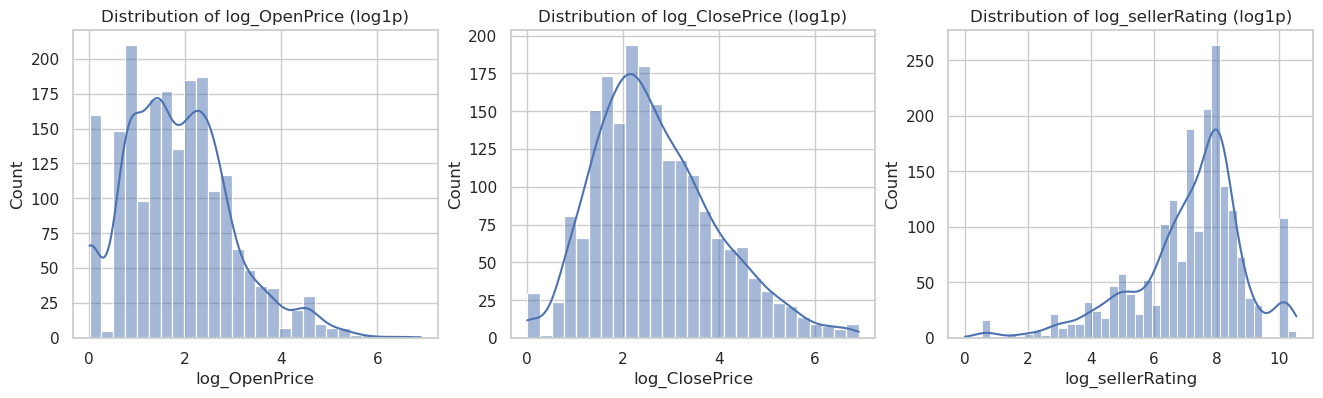

In [5]:
exchange_rates = {"US": 1.0, "EUR": 1.17, "GBP": 1.34}
df["ClosePrice"] = df.apply(lambda row: row["ClosePrice"] * exchange_rates[row["Currency"]], axis=1)
df["OpenPrice"] = df.apply(lambda row: row["OpenPrice"] * exchange_rates[row["Currency"]], axis=1)

# Create transformed versions but keep original for interpretability.
df["log_OpenPrice"] = np.log1p(df["OpenPrice"])
df["log_ClosePrice"] = np.log1p(df["ClosePrice"])
df["log_sellerRating"] = np.log1p(df["sellerRating"])

display(df[["OpenPrice","log_OpenPrice","ClosePrice","log_ClosePrice","sellerRating","log_sellerRating"]].describe())

fig, axes = plt.subplots(1, 3, figsize=(16,4))
for ax, c in zip(axes, ["log_OpenPrice", "log_ClosePrice", "log_sellerRating"]):
    sns.histplot(data=df, x=c, kde=True, ax=ax)
    ax.set_title(f"Distribution of {c} (log1p)")
plt.show()

log transforms compress heavy tails and make thresholds more stable for models like trees/KNN. We keep both raw and log forms for exploration; the practical tree can choose.

### 4. Bivariate relationships vs. `Competitive`

Competitive rate: 0.541


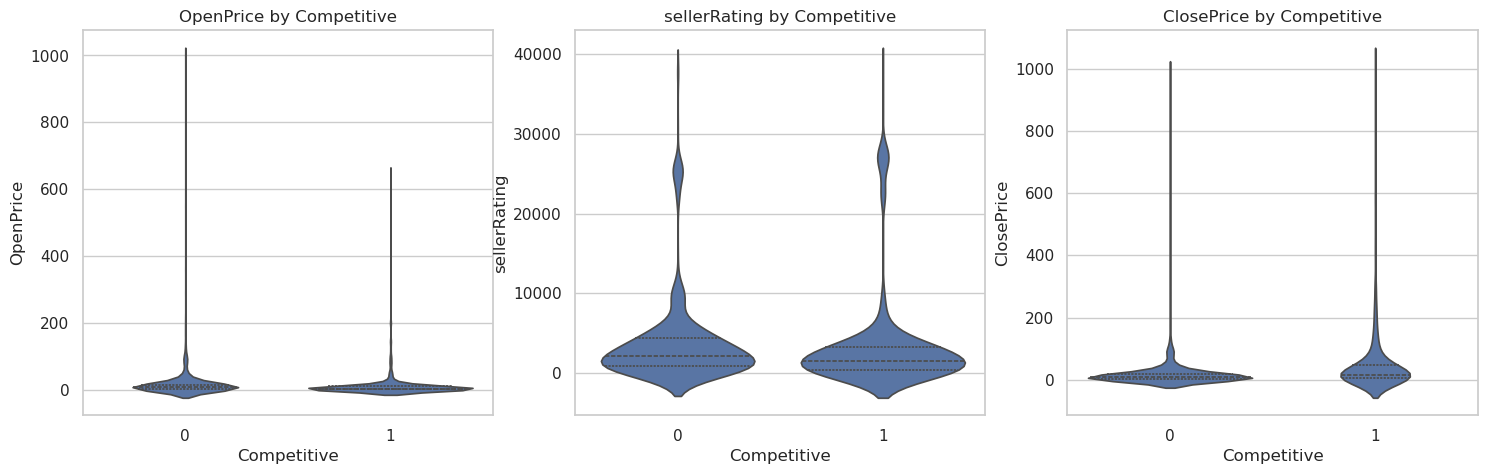

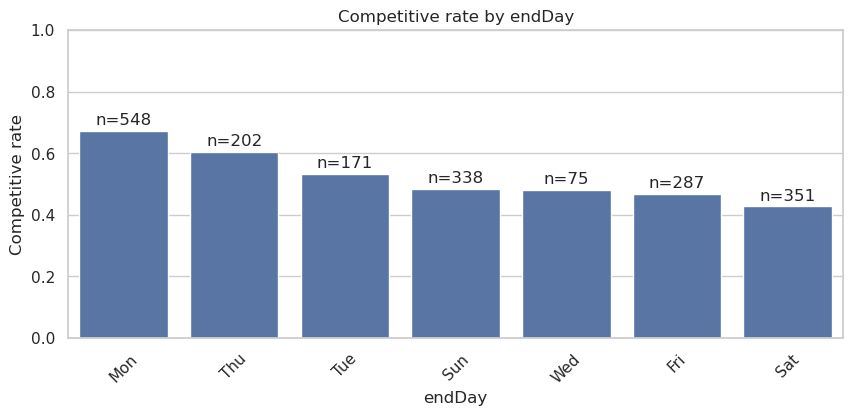

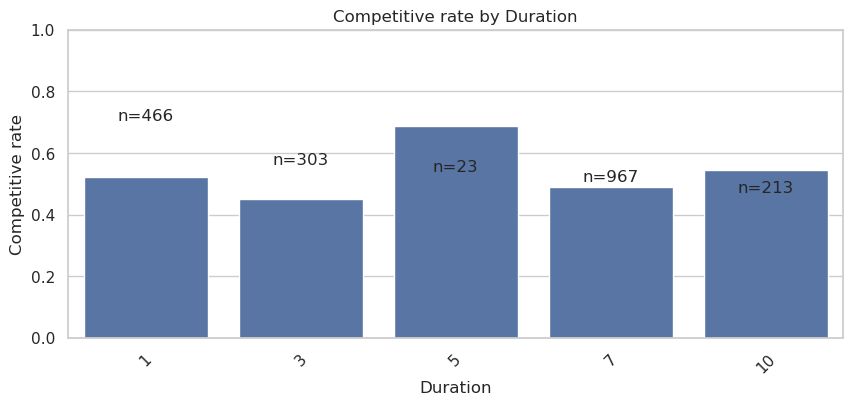

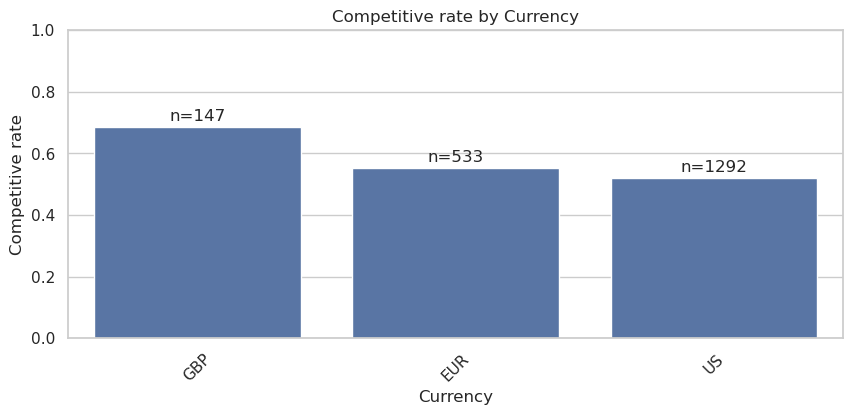

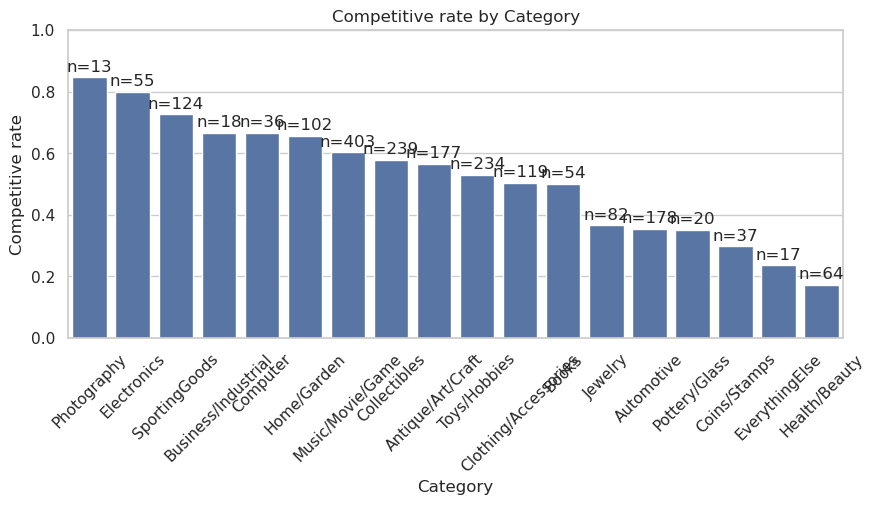

(  endDay      mean  count
 0    Mon  0.673358    548
 1    Thu  0.603960    202
 2    Tue  0.532164    171
 3    Sun  0.485207    338
 4    Wed  0.480000     75,
    Duration      mean  count
 0         5  0.686695    466
 1        10  0.544554    303
 2         1  0.521739     23
 3         7  0.489142    967
 4         3  0.450704    213,
   Currency      mean  count
 0      GBP  0.687075    147
 1      EUR  0.551595    533
 2       US  0.519350   1292)

In [6]:
# Competitive rate overall
print("Competitive rate:", df["Competitive"].mean().round(3))

# Numeric vs Competitive
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for ax, c in zip(axes, ["OpenPrice","sellerRating","ClosePrice"]):
    sns.violinplot(data=df, x="Competitive", y=c, inner="quartile", ax=ax)
    ax.set_title(f"{c} by Competitive")
plt.show()

# Categorical vs Competitive: rates
def rate_barplot(col):
    tmp = (df.groupby(col)["Competitive"]
             .agg(["mean","count"])
             .sort_values("mean", ascending=False)
             .reset_index())
    plt.figure(figsize=(10,4))
    sns.barplot(data=tmp, x=col, y="mean")
    for i,row in tmp.iterrows():
        plt.text(i, row["mean"]+0.01, f"n={int(row['count'])}", ha="center", va="bottom", rotation=0)
    plt.ylabel("Competitive rate")
    plt.ylim(0,1)
    plt.title(f"Competitive rate by {col}")
    plt.xticks(rotation=45)
    plt.show()
    return tmp

cat_rate_tables = {}
for col in ["endDay", "Duration", "Currency", "Category"]:
    cat_rate_tables[col] = rate_barplot(col)

cat_rate_tables["endDay"].head(), cat_rate_tables["Duration"].head(), cat_rate_tables["Currency"].head()

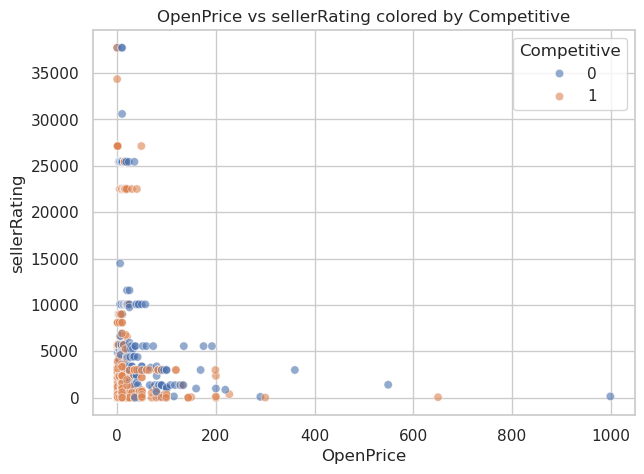

In [7]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="OpenPrice", y="sellerRating", hue="Competitive", alpha=0.6)
plt.title("OpenPrice vs sellerRating colored by Competitive")
plt.show()

### 5. Correlations among numeric features

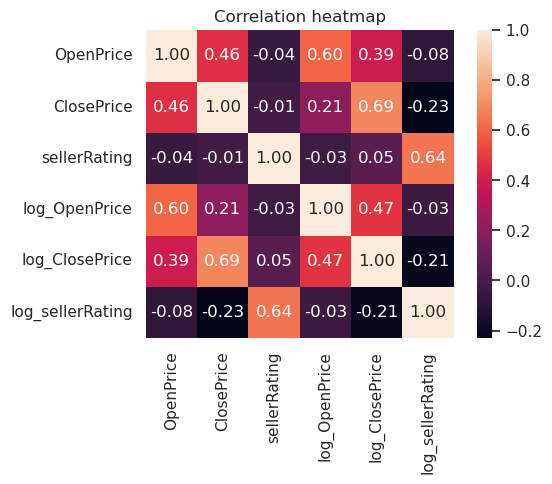

In [8]:
num_for_corr = ["OpenPrice","ClosePrice","sellerRating","log_OpenPrice","log_ClosePrice","log_sellerRating"]
corr = df[num_for_corr].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", square=True)
plt.title("Correlation heatmap")
plt.show()


## Task 2 — KNN Classifier

### 1. Data Split into Training and Test Data 

We split the data into training and test sets with a 60%/40% split as suggested in the instruction. The predictors and response variable in our data are:  
 - **Response:** `Competitive?`
 - **Categorical predictors:** `Category`, `Duration`, and `endDay`
 - **Numeric predictors:** `log_selletRating`, and `log_OpenPriceUSD`

In [9]:
cat_cols = ["Category", "Currency", "endDay", "Duration"]
num_cols = ["log_sellerRating", "log_OpenPrice"]

df_model = df.copy()
X_full = df_model[cat_cols + num_cols]
y = df_model["Competitive"].astype(int)

print("X_full shape:", X_full.shape)
X_full.head()

X_full shape: (1972, 6)


,Category,Currency,endDay,Duration,log_sellerRating,log_OpenPrice
0,Music/Movie/Game,US,Mon,5,8.08641,0.00995
1,Music/Movie/Game,US,Mon,5,8.08641,0.00995
2,Music/Movie/Game,US,Mon,5,8.08641,0.00995
3,Music/Movie/Game,US,Mon,5,8.08641,0.00995
4,Music/Movie/Game,US,Mon,5,8.08641,0.00995


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.4, random_state=RANDOM_STATE, stratify=y)

print("X_train shape:", X_train.shape)
display(X_train.head(10))
y_train

X_train shape: (1183, 6)


,Category,Currency,endDay,Duration,log_sellerRating,log_OpenPrice
1833,Antique/Art/Craft,US,Mon,7,8.387312,3.749269
1196,Home/Garden,EUR,Sun,10,2.944439,2.103585
1071,Music/Movie/Game,EUR,Sun,7,5.327876,2.404573
1000,Music/Movie/Game,US,Sat,7,6.532334,2.014903
1776,Automotive,US,Sun,5,7.218910,3.464172
1395,Automotive,US,Sat,3,2.944439,2.396986
1005,Music/Movie/Game,US,Sat,7,6.532334,2.014903
51,Music/Movie/Game,US,Mon,5,8.086410,0.009950
1485,Music/Movie/Game,US,Mon,5,7.407318,2.393339
1221,Music/Movie/Game,US,Sun,7,10.538158,2.301585


1833    0
1196    0
1071    0
1000    0
1776    0
       ..
1288    0
597     0
1919    1
1438    1
1267    1
Name: Competitive, Length: 1183, dtype: int64

### 2. Apply Standardization on Numeric Predictors

Since we are fitting a KNN model, which is very sensitive to the scales of numeric data, we also have to apply the standardization on numeric predictors. To perform the transformations on numeric columns, we will use a `ColumnTransformer`. Then we will wrap the transformation in a `pipeline` so that we are only fitting the transformer on training data and applying the transformation on training and test data so that we can avoid data leakage problems.

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="passthrough",
)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier())
])

### 3. K-Fold Cross Validation

Now we can use k-fold Cross Validation to find the best value of k for our KNN model. Since this is a classification problem, we are using `accuracy` as the scoring method when comparing the performance of KNN models with different values of k. The `accuracy` measures the fraction of correct predictions by our model.

In [12]:
# Defining the parameters in k-fold CV
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_STATE)
k_values = np.arange(1, 20)
param_grid = {"knn__n_neighbors": k_values}

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=kfold, scoring='accuracy')
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.693982 using {'knn__n_neighbors': np.int64(5)}


Text(0, 0.5, 'Accuracy')

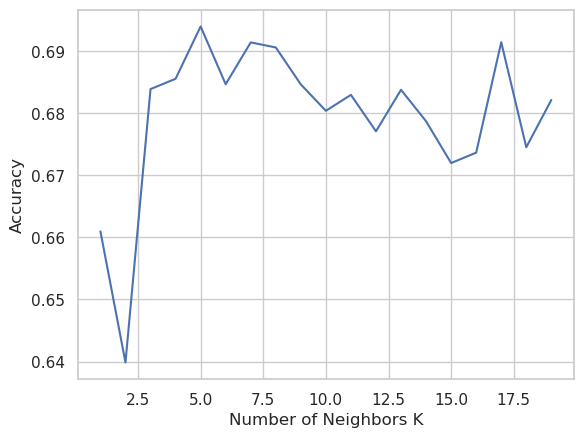

In [13]:
means = grid_result.cv_results_["mean_test_score"]
plt.plot(k_values, means)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Accuracy")

### 4. Fitting the KNN Classifier with the Best K Value

From the cross validation above, we have found that the best value of k when fitting the KNN classifier on our data is at `k = 1`. However, with `k = 1`, we doubt that such a model will be more likely to overfit on the training data. From the validation accuracy score plot, we can see that a KNN classifier with `k = 6` also gives us a reasonably good validation accuracy. Therefore, in this section we will fit a KNN classifier with `k = 1` and `k = 6` separately and compare their predictions on the test data.

In [14]:
pipe_k5 = Pipeline([
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])
pipe_k5.fit(X_train, y_train)
estimates_k5 = pipe_k5.predict(X_test)

In [15]:
acc5 = accuracy_score(y_test, estimates_k5)
print("Accuracy:", acc5)

Accuracy: 0.7008871989860583


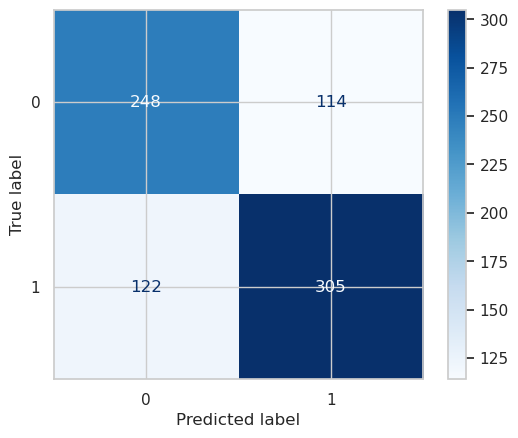

In [16]:
cm5 = confusion_matrix(y_test, estimates_k5)
cm5_display = ConfusionMatrixDisplay(confusion_matrix=cm5, display_labels=pipe_k5.classes_)
cm5_display.plot(cmap="Blues")


## Task 3 — Classification Tree(s)

### 1. Full tree using **all predictors** (including `ClosePrice`)
- **Purpose**: Diagnostic/insight. Note `ClosePrice` is not known ahead of time, so this tree is **not** for practical prediction at listing time.


#### Dummy variables for modeling

In [17]:
# We'll keep Duration as categorical (discrete day counts) for interpretability in trees & KNN.
cat_cols = ["Category","Currency","endDay","Duration"]
num_cols_base = ["sellerRating","OpenPrice","ClosePrice"]

df_model = df.copy()
X_full = pd.get_dummies(df_model[cat_cols + num_cols_base], drop_first=True)
y = df_model["Competitive"].astype(int)

print("X_full shape:", X_full.shape)
X_full.head()

X_full shape: (1972, 29)


,Duration,sellerRating,OpenPrice,ClosePrice,Category_Automotive,Category_Books,Category_Business/Industrial,Category_Clothing/Accessories,Category_Coins/Stamps,Category_Collectibles,Category_Computer,Category_Electronics,Category_EverythingElse,Category_Health/Beauty,Category_Home/Garden,Category_Jewelry,Category_Music/Movie/Game,Category_Photography,Category_Pottery/Glass,Category_SportingGoods,Category_Toys/Hobbies,Currency_GBP,Currency_US,endDay_Mon,endDay_Sat,endDay_Sun,endDay_Thu,endDay_Tue,endDay_Wed
0,5,3249,0.01,0.01,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False
1,5,3249,0.01,0.01,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False
2,5,3249,0.01,0.01,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False
3,5,3249,0.01,0.01,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False
4,5,3249,0.01,0.01,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

tree_all = DecisionTreeClassifier(min_samples_leaf=50, random_state=RANDOM_STATE)
tree_all.fit(X_train, y_train)

y_pred = tree_all.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix (All predictors):\n", cm)
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

# Feature importances
imp = pd.Series(tree_all.feature_importances_, index=X_full.columns).sort_values(ascending=False)
imp.head(10)

Confusion matrix (All predictors):
 [[224  48]
 [ 64 256]]

Classification report:
               precision    recall  f1-score   support

           0      0.778     0.824     0.800       272
           1      0.842     0.800     0.821       320

    accuracy                          0.811       592
   macro avg      0.810     0.812     0.810       592
weighted avg      0.813     0.811     0.811       592



ClosePrice                       0.473409
OpenPrice                        0.457063
sellerRating                     0.069527
Duration                         0.000000
Category_Automotive              0.000000
Category_Books                   0.000000
Category_Business/Industrial     0.000000
Category_Clothing/Accessories    0.000000
Category_Coins/Stamps            0.000000
Category_Collectibles            0.000000
dtype: float64

#### Summarize the resulting rules

In [19]:
def extract_rules(decision_tree, feature_names):
    tree_ = decision_tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # left
            left_path = path.copy()
            left_path.append(f"({name} <= {threshold:.2f})")
            recurse(tree_.children_left[node], left_path, paths)
            # right
            right_path = path.copy()
            right_path.append(f"({name} > {threshold:.2f})")
            recurse(tree_.children_right[node], right_path, paths)
        else:
            path_str = " AND ".join(path)
            value = tree_.value[node][0]
            pred = int(np.argmax(value))
            support = int(np.sum(value))
            paths.append((path_str, pred, support))

    recurse(0, path, paths)
    rules = pd.DataFrame(paths, columns=["Rule", "PredictedClass", "Support"]).sort_values("Support", ascending=False)
    return rules

rules_all = extract_rules(tree_all, X_full.columns)
rules_all.head(10)

,Rule,PredictedClass,Support
0,(OpenPrice <= 3.67) AND (ClosePrice <= 3.67) A...,1,1
1,(OpenPrice <= 3.67) AND (ClosePrice <= 3.67) A...,0,1
2,(OpenPrice <= 3.67) AND (ClosePrice <= 3.67) A...,1,1
3,(OpenPrice <= 3.67) AND (ClosePrice <= 3.67) A...,0,1
4,(OpenPrice <= 3.67) AND (ClosePrice > 3.67),1,1
5,(OpenPrice > 3.67) AND (ClosePrice <= 10.00) A...,0,1
6,(OpenPrice > 3.67) AND (ClosePrice <= 10.00) A...,0,1
7,(OpenPrice > 3.67) AND (ClosePrice <= 10.00) A...,0,1
8,(OpenPrice > 3.67) AND (ClosePrice <= 10.00) A...,0,1
9,(OpenPrice > 3.67) AND (ClosePrice > 10.00) AN...,1,1


In [20]:
rules_all.Rule[1]

'(OpenPrice <= 3.67) AND (ClosePrice <= 3.67) AND (OpenPrice > 0.85) AND (ClosePrice <= 2.15)'

Look for thresholds on `OpenPrice`, `ClosePrice`, and `sellerRating` — these usually dominate.

#### Plot the tree (all predictors)

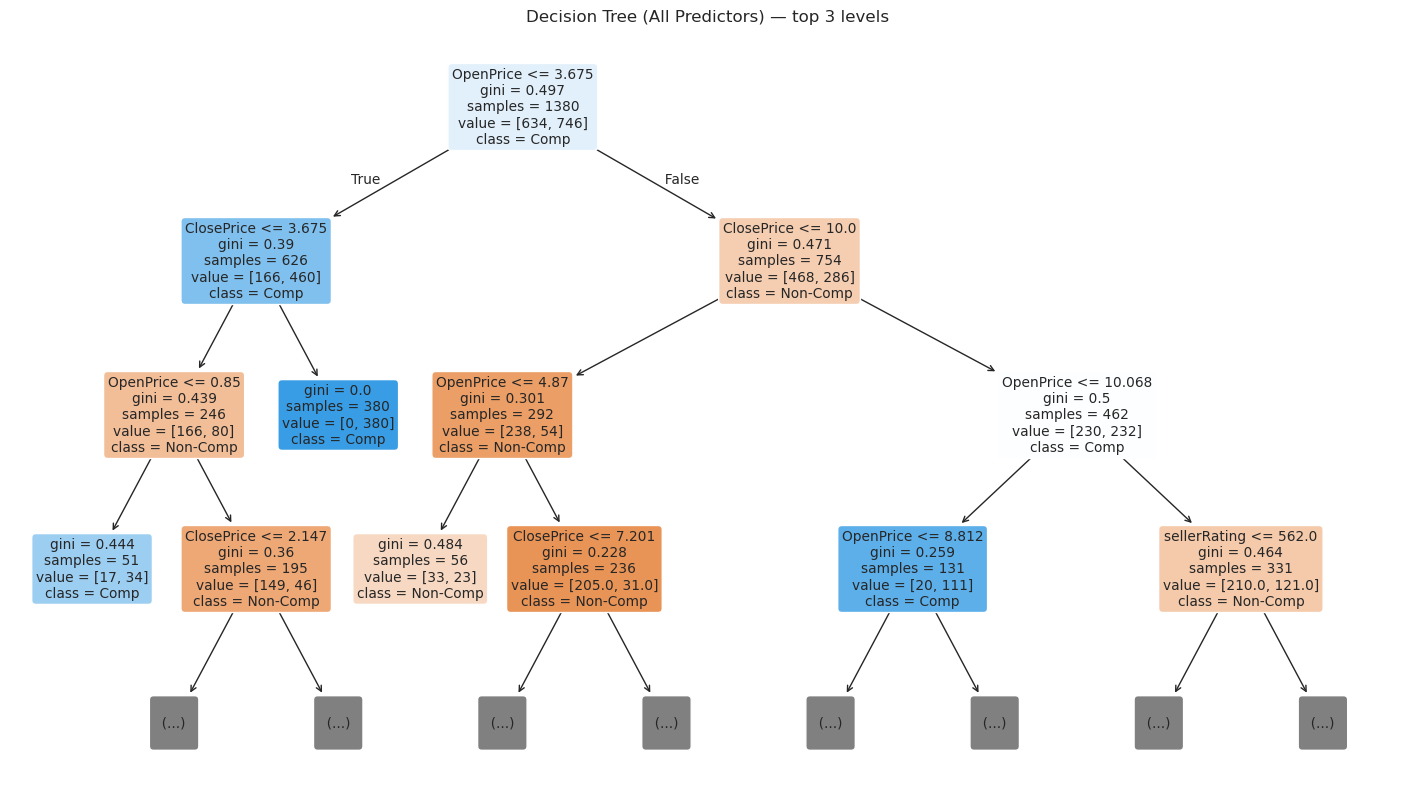

In [21]:
plt.figure(figsize=(18, 10))
plot_tree(tree_all, feature_names=X_full.columns, class_names=["Non-Comp","Comp"], filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree (All Predictors) — top 3 levels")
plt.show()

**A Text format structure for FULL tree:**

In [22]:
print(export_text(tree_all, feature_names=X_full.columns))

|--- OpenPrice <= 3.67
|   |--- ClosePrice <= 3.67
|   |   |--- OpenPrice <= 0.85
|   |   |   |--- class: 1
|   |   |--- OpenPrice >  0.85
|   |   |   |--- ClosePrice <= 2.15
|   |   |   |   |--- class: 0
|   |   |   |--- ClosePrice >  2.15
|   |   |   |   |--- OpenPrice <= 2.86
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- OpenPrice >  2.86
|   |   |   |   |   |--- class: 0
|   |--- ClosePrice >  3.67
|   |   |--- class: 1
|--- OpenPrice >  3.67
|   |--- ClosePrice <= 10.00
|   |   |--- OpenPrice <= 4.87
|   |   |   |--- class: 0
|   |   |--- OpenPrice >  4.87
|   |   |   |--- ClosePrice <= 7.20
|   |   |   |   |--- OpenPrice <= 6.46
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- OpenPrice >  6.46
|   |   |   |   |   |--- class: 0
|   |   |   |--- ClosePrice >  7.20
|   |   |   |   |--- class: 0
|   |--- ClosePrice >  10.00
|   |   |--- OpenPrice <= 10.07
|   |   |   |--- OpenPrice <= 8.81
|   |   |   |   |--- class: 1
|   |   |   |--- OpenPrice >  8.81
|   |   |   | 


### 2. **Practical tree** (predictable at listing time only)

We drop **`ClosePrice`** and use only predictors that are available *before* the auction:  
- `OpenPrice`, `sellerRating`, `Category`, `Currency`, `Duration`, `endDay`.


In [23]:
usable_cols = ["Category","Currency","endDay","Duration","sellerRating","OpenPrice"]
X_use = pd.get_dummies(df_model[usable_cols], drop_first=True)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_use, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

tree_use = DecisionTreeClassifier(min_samples_leaf=50, random_state=RANDOM_STATE)
tree_use.fit(X_train2, y_train2)

y_pred2 = tree_use.predict(X_test2)

#### Plot the tree (usable predictors)

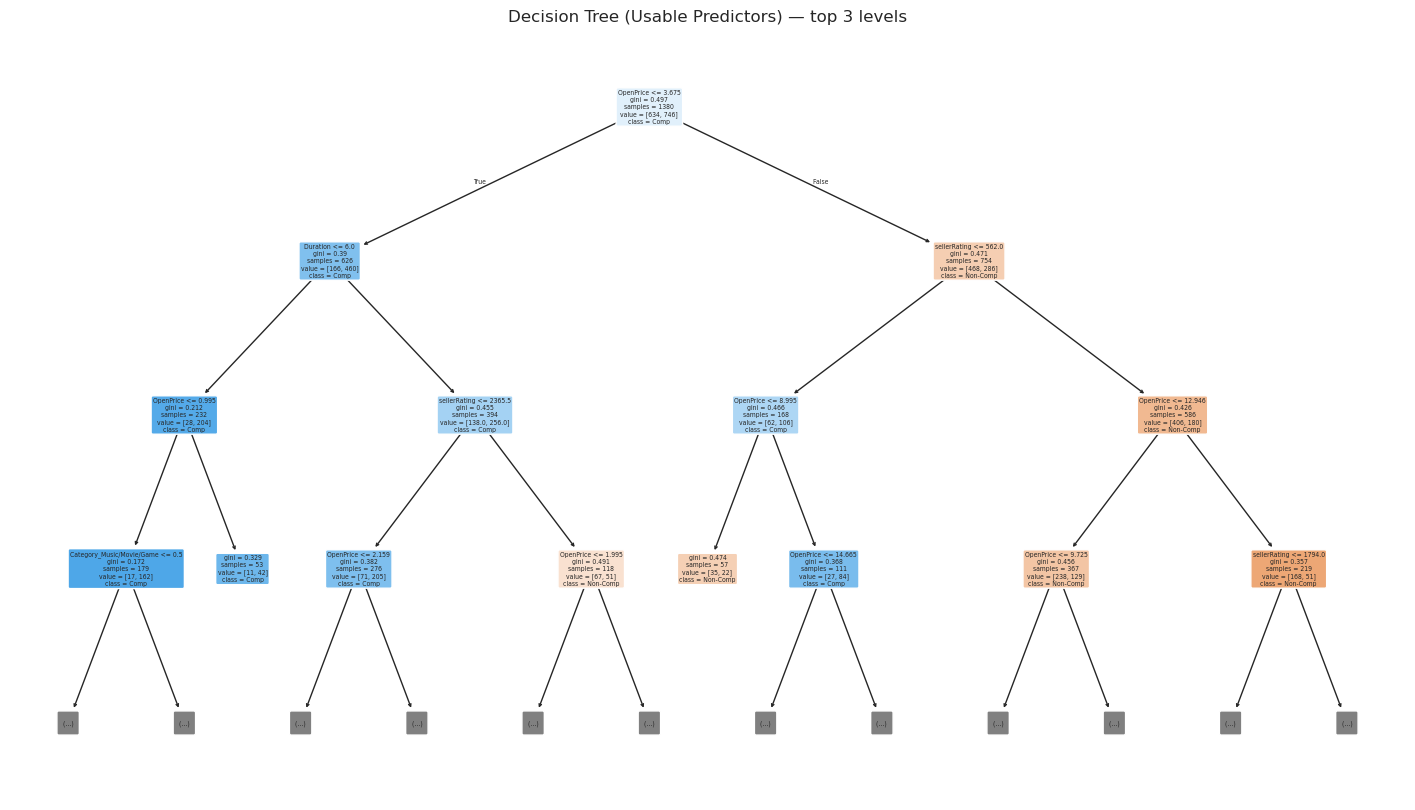

In [24]:
plt.figure(figsize=(18, 10))
plot_tree(tree_use, feature_names=X_use.columns, class_names=["Non-Comp","Comp"], filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree (Usable Predictors) — top 3 levels")
plt.show()

**A Text format structure for pratical tree:**

In [25]:
print(export_text(tree_use, feature_names=X_use.columns))

|--- OpenPrice <= 3.67
|   |--- Duration <= 6.00
|   |   |--- OpenPrice <= 1.00
|   |   |   |--- Category_Music/Movie/Game <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Category_Music/Movie/Game >  0.50
|   |   |   |   |--- class: 1
|   |   |--- OpenPrice >  1.00
|   |   |   |--- class: 1
|   |--- Duration >  6.00
|   |   |--- sellerRating <= 2365.50
|   |   |   |--- OpenPrice <= 2.16
|   |   |   |   |--- sellerRating <= 850.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- sellerRating >  850.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- OpenPrice >  2.16
|   |   |   |   |--- sellerRating <= 624.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- sellerRating >  624.00
|   |   |   |   |   |--- class: 1
|   |   |--- sellerRating >  2365.50
|   |   |   |--- OpenPrice <= 2.00
|   |   |   |   |--- class: 1
|   |   |   |--- OpenPrice >  2.00
|   |   |   |   |--- class: 0
|--- OpenPrice >  3.67
|   |--- sellerRating <= 562.00
|   |   |--- OpenPrice <= 8.99
|  

#### Scatter plot with two best quantitative predictors & tree split lines

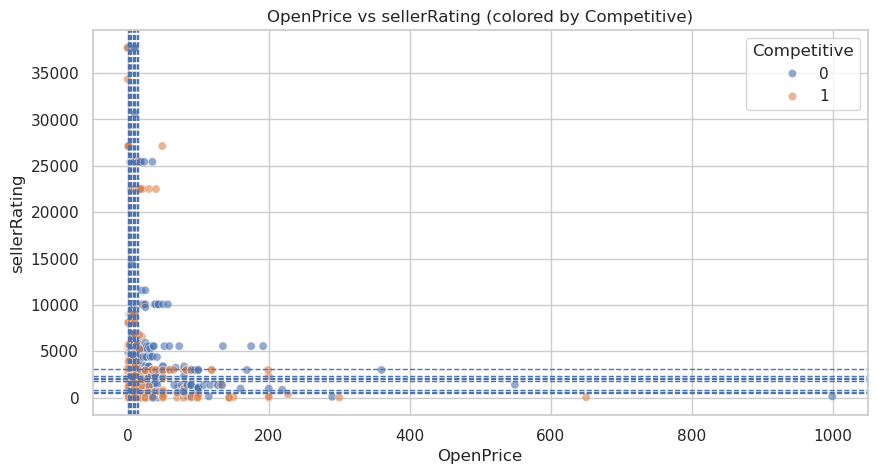

In [26]:
# Identify two best numeric predictors for the practical tree
two_numeric = ["OpenPrice","sellerRating"]  # typically dominate; easy to interpret

plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x="OpenPrice", y="sellerRating", hue="Competitive", alpha=0.6)
plt.title("OpenPrice vs sellerRating (colored by Competitive)")

# Extract split thresholds used by the practical tree on these two features
thresholds = []
tree_ = tree_use.tree_
feat_names = X_use.columns.tolist()
for node_idx in range(tree_.node_count):
    feat_idx = tree_.feature[node_idx]
    if feat_idx == _tree.TREE_UNDEFINED:
        continue
    feat_name = feat_names[feat_idx]
    thr = tree_.threshold[node_idx]
    # Only draw lines for the raw numeric columns (not dummies)
    if feat_name in two_numeric:
        thresholds.append((feat_name, thr))

# Draw unique thresholds
for name, thr in sorted(set(thresholds)):
    if name == "OpenPrice":
        plt.axvline(thr, linestyle="--", linewidth=1)
    elif name == "sellerRating":
        plt.axhline(thr, linestyle="--", linewidth=1)

plt.show()

**The raw scatter of OpenPrice vs. sellerRating is hard to read, so we cut the X and Y into a narrower range to visualize the decision boundaries more clearly.**

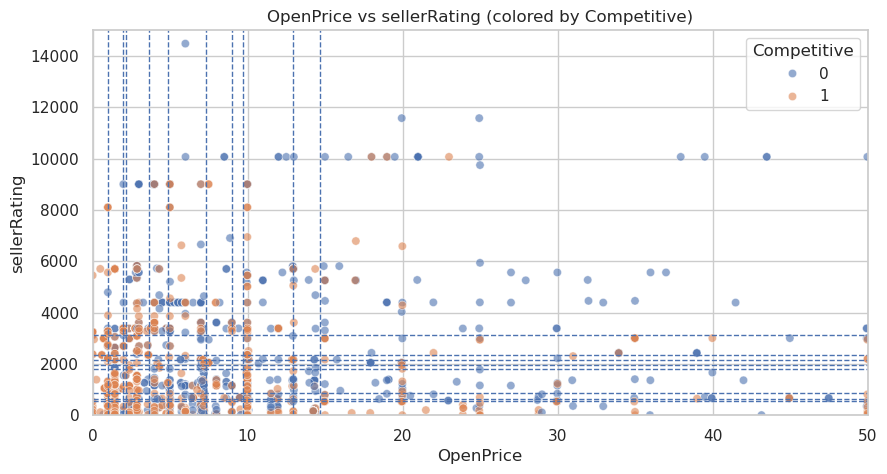

In [27]:
# Identify two best numeric predictors for the practical tree
two_numeric = ["OpenPrice","sellerRating"]  # typically dominate; easy to interpret

plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=df, x="OpenPrice", y="sellerRating",
                     hue="Competitive", alpha=0.6)
ax.set_title("OpenPrice vs sellerRating (colored by Competitive)")

ax.set_xlim(0, 50)
ax.set_ylim(0, 15000) 

# Extract split thresholds used by the practical tree on these two features
thresholds = []
tree_ = tree_use.tree_
feat_names = X_use.columns.tolist()
for node_idx in range(tree_.node_count):
    feat_idx = tree_.feature[node_idx]
    if feat_idx == _tree.TREE_UNDEFINED:
        continue
    feat_name = feat_names[feat_idx]
    thr = tree_.threshold[node_idx]
    # Only draw lines for the raw numeric columns (not dummies)
    if feat_name in two_numeric:
        thresholds.append((feat_name, thr))

# Draw unique thresholds
for name, thr in sorted(set(thresholds)):
    if name == "OpenPrice":
        ax.axvline(thr, linestyle="--", linewidth=1)
    elif name == "sellerRating":
        ax.axhline(thr, linestyle="--", linewidth=1)

plt.show()

Are the splits reasonable given the meaning of the predictors?

Yes.
- OpenPrice (vertical lines): Most thresholds sit at small dollar “notches” (≈ \\$1–\\$15). Those are exactly where buyer sensitivity is steep and where sellers commonly choose starting prices. Economically, low starts spur early bids and momentum; once the opening price passes \\$10–\\$15, demand thins.

- sellerRating (horizontal lines): Several cutpoints lie around a few hundred to a few thousand feedback points (≈ 500, 1k, 1.5k, 2–3k). That reflects plausible trust thresholds: credibility helps the auction attract at least two bids, especially when the opening price isn’t too high.

- Interaction structure: Price acts as the primary gate; within a price band, sellerRating refines the decision—exactly the mechanism the tree implies.

Do the splits separate the classes well?

Partially—good in the broad strokes, but not cleanly.
- Clear regions:
    - OpenPrice $≤$ ~\\$5 with sellerRating $≥$ 1k shows a noticeably higher share of competitive (orange) auctions.
    - OpenPrice $≥$ ~\\$15 is mostly non-competitive (blue), even with decent ratings.
    - In the \\$5–\\$10 band, sellerRating matters more: higher ratings tilt the mix toward orange.
    
- Remaining overlap:
    - At very low prices, you still see a mix of orange and blue—reputation, category, end day, and duration still influence outcomes.
    - Axis-aligned splits can’t express a smooth trade-off like “if price inches up, you need proportionally more rating,” so some diagonal structure escapes the tree.

#### Confusion Matrix & Classification Report Table & TOP 10 Importance Features

In [28]:
cm2 = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix (Usable predictors):\n", cm2)
print("\nClassification report:\n", classification_report(y_test2, y_pred2, digits=3))

imp2 = pd.Series(tree_use.feature_importances_, index=X_use.columns).sort_values(ascending=False)
imp2.head(10)

Confusion matrix (Usable predictors):
 [[184  88]
 [ 89 231]]

Classification report:
               precision    recall  f1-score   support

           0      0.674     0.676     0.675       272
           1      0.724     0.722     0.723       320

    accuracy                          0.701       592
   macro avg      0.699     0.699     0.699       592
weighted avg      0.701     0.701     0.701       592



OpenPrice                        0.618181
sellerRating                     0.296990
Duration                         0.079587
Category_Music/Movie/Game        0.005242
Category_Books                   0.000000
Category_Business/Industrial     0.000000
Category_Clothing/Accessories    0.000000
Category_Coins/Stamps            0.000000
Category_Collectibles            0.000000
Category_Computer                0.000000
dtype: float64

**Interpretation:**

- Accuracy = 0.701; the tree gets about 70% of auctions right on the hold-out set.
- Class 1 (Competitive)
    - Precision 0.724: when the model predicts “competitive,” it’s right ~72% of the time.
    - Recall 0.722: it captures ~72% of the truly competitive auctions.
    - F1 0.723: balanced precision/recall.
- 	Class 0 (Non-competitive)
    - Precision 0.674, Recall 0.676, F1 0.675: slightly worse than class 1, but close.
    
The tree captures real signal (open price + seller rating + settings) and gives usable lift over baseline, especially for identifying competitive auctions (both precision and recall ~0.72).

#### Rules (usable predictors)

In [29]:
rules_use = extract_rules(tree_use, X_use.columns)
rules_use.head(12)

,Rule,PredictedClass,Support
0,(OpenPrice <= 3.67) AND (Duration <= 6.00) AND...,1,1
1,(OpenPrice <= 3.67) AND (Duration <= 6.00) AND...,1,1
2,(OpenPrice <= 3.67) AND (Duration <= 6.00) AND...,1,1
3,(OpenPrice <= 3.67) AND (Duration > 6.00) AND ...,1,1
4,(OpenPrice <= 3.67) AND (Duration > 6.00) AND ...,1,1
5,(OpenPrice <= 3.67) AND (Duration > 6.00) AND ...,1,1
6,(OpenPrice <= 3.67) AND (Duration > 6.00) AND ...,1,1
7,(OpenPrice <= 3.67) AND (Duration > 6.00) AND ...,1,1
8,(OpenPrice <= 3.67) AND (Duration > 6.00) AND ...,0,1
9,(OpenPrice > 3.67) AND (sellerRating <= 562.00...,0,1


### 3. Which predictors to keep if we must reduce dimensionality?

In [30]:
print("Top 10 importances (practical tree):")
imp2.head(10)

Top 10 importances (practical tree):


OpenPrice                        0.618181
sellerRating                     0.296990
Duration                         0.079587
Category_Music/Movie/Game        0.005242
Category_Books                   0.000000
Category_Business/Industrial     0.000000
Category_Clothing/Accessories    0.000000
Category_Coins/Stamps            0.000000
Category_Collectibles            0.000000
Category_Computer                0.000000
dtype: float64

Recommendation: Keep `OpenPrice` and `sellerRating` as the strongest quantitative drivers, optionally add `Duration` and `endDay` (coarse effects), and the strongest category dummies (if any).


## Conclusions & Recommendations

- **Obvious finding**: Lower **`OpenPrice`** strongly increases the chance of being competitive (it attracts initial bids).
- **Seller reputation** (`sellerRating`) matters: higher ratings associate with higher competitiveness, conditional on price.
- **Auction settings**:
  - **Duration**: 5-day auctions showed relatively higher competitive rates (in this sample), though 7- and 10-day also do fine.
  - **Ending day**: **Monday** and **Thursday** had higher competitive rates here than weekend endings; effects may be category-dependent.
  - **Currency**: GBP/EUR listings showed slightly higher rates in this sample; mix of categories and geographies likely contributes.
- **Categories**: Some categories (e.g., Photography, Electronics) show higher competitiveness in this sample, but sample sizes vary; use with caution.

**Practical guidance for sellers (from the practical tree):**
1. **Set a low opening price** to entice early bidding and momentum.  
2. **Leverage reputation**: maintain and display strong seller ratings; if new, consider strategies that build feedback first.  
3. **Choose duration wisely** (e.g., 5–7 days) and avoid low-activity end times; consider **Mon/Thu** endings (sample-specific).  
4. **Category nuances** exist — align price strategy with typical demand and competitor pricing.

> **Is the model practical?**  
> Yes, the **practical tree** (excluding `ClosePrice`) is simple to implement and interpret at listing time. Accuracy is lower than the full-information tree (as expected), but still helpful for decision support.

> **Classification table** is printed above for both trees. Prefer the practical tree for prediction at listing time.
